## Algorithme EM et Gradient Stochastique

Vous avez collecté les durées de vie $t_1, \dots, t_n$ (en années) de $n = 19830$ ampoules issues de deux lots (1 et 2) différents. Vous avez sauvegardé ces données dans le fichier temps.txt mais l’information du lot $l_1, \dots, l_n \in (1,2)$ correspondant à chacune des durées de vie $t_1, \dots, t_n$ a été perdue et vous aimeriez la retrouver.

On modélise la distribution des durées de vie des ampoules des lots 1 et 2 par des lois Gamma $\Gamma(v_1, \theta_1)$ et $\Gamma(v_1, \theta_1)$. On rappelle que la densité d’une loi gamma $\Gamma(v, \theta)$ est donnée par :
$$
    f(t) = \frac{1}{\theta^v \Gamma(v)} t^{v-1} e^{-\frac{t}{\theta}}, \quad t > 0.
$$

On notera $p$ la proportion inconnue d’ampoules du lot numéro 1. Les paramètres inconnus du modèle seront décrits par :
$
    \Theta = (p, \mu_1, v_1, \theta_1, \theta_2).
$
On notera $T$ la variable aléatoire modélisant la durée de vie d’une ampoule de l’échantillon et $L$ la variable aléatoire modélisant le numéro du lot dont elle est issue.

- Mettre en place dn le cadre théorique de l’algorithme EM.
Nous mettons en place le cadre théorique de l’algorithme Expectation-Maximization (EM). Nous précisons notamment la fonction $F_{\Theta^{'}}(\Theta)$ à minimiser pour mettre à jour les paramètres du modèle.

- Implémentation du gradient stochastique
Nous implémentons la méthode du gradient stochastique permettant de minimiser $F_{\theta^{'}}$. Pour l’initialisation des paramètres, nous exprimons $(v, \theta)$ en fonction de la moyenne et de la variance d’une loi $\Gamma(v, \theta)$ :
$$
    \mathbb{E}[T] = \frac{v}{\theta}, \quad \text{Var}(T) = \frac{v}{\theta^2}.
$$

Variante : Algorithme du recuit simulé


Nous implémentons l’algorithme du recuit simulé comme alternative au gradient stochastique.

- Implémentation de l’algorithme EM et résultats
Nous implémentons l’algorithme EM, que nous testons d’abord sur des données simulées. Nous donnons ensuite une estimation de la proportion d’ampoules du lot 1 et des durées de vie moyennes des lots.

- Comparaison des vitesses de convergence
Nous comparons la vitesse de convergence de l’algorithme EM avec celle de l’algorithme consistant à mettre à jour la moyenne et la variance avec les estimateurs classiques de ces quantités.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
from scipy.special import digamma, gamma
from scipy.stats import gamma as gamma_dist

In [2]:
t = np.loadtxt('temps.txt')
n = len(t)

In [3]:
# Initialisation basée sur les moments
def initialisation(t):
    p = 0.5
    mu = np.mean(t)
    var = np.var(t)
    
    # Initialisation pour v1 et theta1 (lot 1)
    v1 = (mu**2)/var
    theta1 = v1/mu
    
    # Initialisation pour v2 et theta2 (lot 2)
    v2 = v1  # On suppose la même forme initiale
    theta2 = theta1 * 1.5  # On décale légèrement theta
    
    return p, v1, theta1, v2, theta2

In [10]:
print(initialisation(t))

(0.5, 4.787234411463304, 0.6067764173482791, 4.787234411463304, 0.9101646260224188)


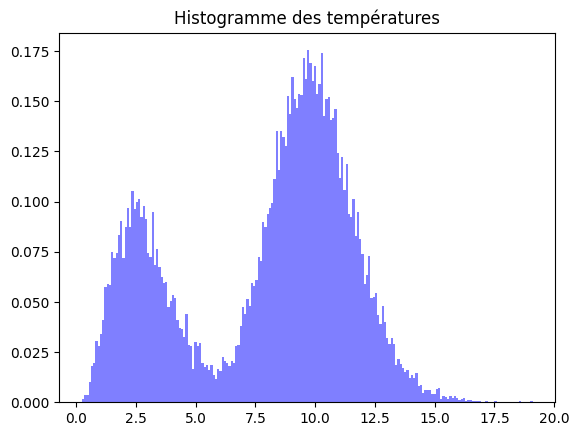

In [12]:
#visualisation des donnees
plt.hist(t, bins=200, density=True, color='blue', alpha=0.5)
plt.title('Histogramme des températures')
plt.show()

In [13]:
#la code de la densité d'une loi gamma 
def gamma_density(t, v, theta):
    return (1/(theta**v * gamma(v))) * t**(v-1) * np.exp(-t/theta)

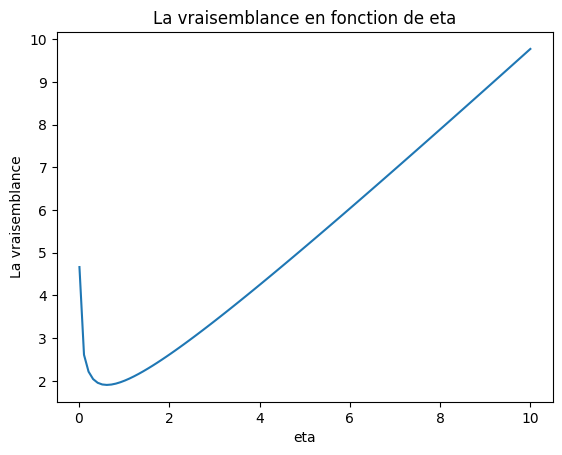

In [16]:
# Calcul de la log-vraisemblance pour le paramètre eta (v) avec alpha comme terme supplémentaire
alpha = 1
def log_likelihood(eta, alpha):
    return np.log(gamma(eta)) - eta * np.log(eta) + eta * (1 + alpha)

# Génération des valeurs pour eta
t = np.linspace(0.01, 10, 100)
# Calcul de la log-vraisemblance pour chaque eta
plt.plot(t, log_likelihood(t, alpha))
plt.xlabel('eta')
plt.ylabel('La vraisemblance')
plt.title('La vraisemblance en fonction de eta')
plt.show()

eta optimal : 0.6155567717918535


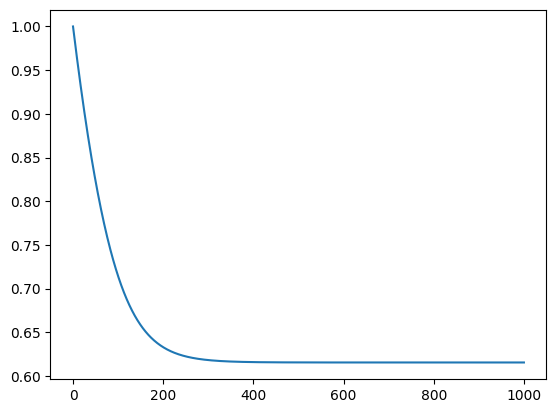

In [18]:
#derivé de la log-vraisemblance
def derive_log_likelihood(eta, alpha):
    return digamma(eta) - np.log(eta) + alpha

#descente de gradient pour minimiser la log-vraisemblance
etas = []
def gradient_descent(eta, alpha, learning_rate=0.01, max_iter=1000):
    etas = [eta]
    for i in range(max_iter):
        eta = eta - learning_rate * derive_log_likelihood(eta, alpha)
        etas.append(eta)
    return eta, etas

# Initialisation de eta
alpha, eta = 1, 1
# Calcul de eta optimal
eta, etas = gradient_descent(eta, alpha)
print('eta optimal :', eta)

plt.plot(etas)

In [ ]:
def EM_gamma(t, p, v1, theta1, v2, theta2, max_iter=1000, tol=1e-6):
    #p, v1, theta1, v2, theta2 = initialisation(t) 
    
    for _ in range(max_iter):
        dens1 = gamma_density(t, v1, theta1)
        dens2 = gamma_density(t, v2, theta2)
        ratio = p * dens1 / (p * dens1 + (1 - p) * dens2)
        
        # Mise à jour des paramètres
        p = np.mean(ratio)
        
        alpha = np.log(np.sum(t * ratio)/np.sum(ratio)) -np.sum(np.log(t) * ratio)/ np.sum(ratio)
        alpha2 = np.log(np.sum(t * (1 - ratio))/np.sum(1 - ratio)) -np.sum(np.log(t) * (1 - ratio))/ np.sum(1 - ratio)
        v1 = gradient_descent(v1, alpha)[0]
        v2 = gradient_descent(v2, alpha2)[0]
        
        theta1 = (1/v1) * np.sum(t * ratio) / np.sum(ratio)
        theta2 = (1/v2) * np.sum(t * (1 - ratio)) / np.sum(1 - ratio)
        
    return p, v1, theta1, v2, theta2
        

In [39]:
#test de l'algorithme EM
p, v1, theta1, v2, theta2 = 0.2, 5, 0.7, 40 ,0.2

# Estimation des paramètres
p, v1, theta1, v2, theta2 = EM_gamma(t, p, v1, theta1, v2, theta2)

In [40]:
print(p, v1, theta1, v2, theta2)

0.3017310306756873 4.522729081060032 0.6638648928577984 33.8256271451091 0.29567562825734933


In [42]:
# algo du gradient stochastique
def stochastic_gradient_descent(eta, alpha, a,b, max_iter=1000):
    etas = [eta]
    for i in range(max_iter):
        #idx = npr.randint(0, len(t))
        epsilon = a / (b+i)
        eta = eta - epsilon * derive_log_likelihood(eta, alpha)
        etas.append(eta)
    return eta, etas


In [43]:
a = 10
b = 1

def EM_gamma_gradsto(t, p, v1, theta1, v2, theta2, max_iter=1000, tol=1e-6):
    #p, v1, theta1, v2, theta2 = initialisation(t) 
    
    for _ in range(max_iter):
        dens1 = gamma_density(t, v1, theta1)
        dens2 = gamma_density(t, v2, theta2)
        ratio = p * dens1 / (p * dens1 + (1 - p) * dens2)
        
        # Mise à jour des paramètres
        p = np.mean(ratio)
        
        alpha = np.log(np.sum(t * ratio)/np.sum(ratio)) -np.sum(np.log(t) * ratio)/ np.sum(ratio)
        alpha2 = np.log(np.sum(t * (1 - ratio))/np.sum(1 - ratio)) -np.sum(np.log(t) * (1 - ratio))/ np.sum(1 - ratio)
        v1 = stochastic_gradient_descent(v1, alpha, a,b, max_iter=1000)[0]
        v2 = stochastic_gradient_descent(v2, alpha2, a,b, max_iter=1000)[0]
        
        theta1 = (1/v1) * np.sum(t * ratio) / np.sum(ratio)
        theta2 = (1/v2) * np.sum(t * (1 - ratio)) / np.sum(1 - ratio)
        
    return p, v1, theta1, v2, theta2

In [45]:
print(EM_gamma_gradsto(t, p, v1, theta1, v2, theta2))

(0.3013490305931773, 4.541888169256739, 0.6600505476775065, 33.513786908323596, 0.2983719263855586)


In [46]:
def EM_gamma_classique(t, p, v1, theta1, v2, theta2, max_iter=1000, tol=1e-6):
    #p, v1, theta1, v2, theta2 = initialisation(t) 
    
    for _ in range(max_iter):
        dens1 = gamma_density(t, v1, theta1)
        dens2 = gamma_density(t, v2, theta2)
        ratio = p * dens1 / (p * dens1 + (1 - p) * dens2)
        
        # Mise à jour des paramètres
        p = np.mean(ratio)
        
        alpha = np.log(np.sum(t * ratio)/np.sum(ratio)) -np.sum(np.log(t) * ratio)/ np.sum(ratio)
        alpha2 = np.log(np.sum(t * (1 - ratio))/np.sum(1 - ratio)) -np.sum(np.log(t) * (1 - ratio))/ np.sum(1 - ratio)
        v1 = gradient_descent(v1, alpha)[0]
        v2 = gradient_descent(v2, alpha2)[0]
        
        theta1 = (1/v1) * np.sum(t * ratio) / np.sum(ratio)
        theta2 = (1/v2) * np.sum(t * (1 - ratio)) / np.sum(1 - ratio)
        
    return p, v1, theta1, v2, theta2